In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

1. Load and preprocess CIFAR-10

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

2. Load Pretrained Base Model (VGG16)

In [9]:
base_model = applications.VGG16(
    weights="imagenet",
    include_top=False,      # exclude classifier layers
    input_shape=(32, 32, 3) # CIFAR-10 shape
)

# Freeze convolutional base
for layer in base_model.layers:
    layer.trainable = False


3. Build Custom Classifier on top

In [10]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

# Compile with lower LR for fine-tuning
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

4. Train model

In [11]:
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    x_train, y_train_cat,
    epochs=10, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/10
625/625 - 696s - 1s/step - accuracy: 0.2812 - loss: 2.0113 - val_accuracy: 0.4518 - val_loss: 1.6552
Epoch 2/10
625/625 - 673s - 1s/step - accuracy: 0.4299 - loss: 1.6412 - val_accuracy: 0.4970 - val_loss: 1.4889
Epoch 3/10
625/625 - 637s - 1s/step - accuracy: 0.4674 - loss: 1.5262 - val_accuracy: 0.5171 - val_loss: 1.4125
Epoch 4/10
625/625 - 649s - 1s/step - accuracy: 0.4941 - loss: 1.4553 - val_accuracy: 0.5325 - val_loss: 1.3645
Epoch 5/10
625/625 - 634s - 1s/step - accuracy: 0.5109 - loss: 1.4109 - val_accuracy: 0.5415 - val_loss: 1.3307
Epoch 6/10
625/625 - 687s - 1s/step - accuracy: 0.5259 - loss: 1.3740 - val_accuracy: 0.5483 - val_loss: 1.3038
Epoch 7/10
625/625 - 619s - 990ms/step - accuracy: 0.5346 - loss: 1.3406 - val_accuracy: 0.5577 - val_loss: 1.2825
Epoch 8/10
625/625 - 636s - 1s/step - accuracy: 0.5431 - loss: 1.3221 - val_accuracy: 0.5637 - val_loss: 1.2636
Epoch 9/10
625/625 - 627s - 1s/step - accuracy: 0.5454 - loss: 1.3043 - val_accuracy: 0.5663 - val_lo

5. Evaluate on Test Set


Test Accuracy: 0.5631
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 406ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane     0.6128    0.6520    0.6318      1000
  automobile     0.6063    0.5990    0.6026      1000
        bird     0.4845    0.3900    0.4321      1000
         cat     0.4326    0.3950    0.4130      1000
        deer     0.5312    0.5110    0.5209      1000
         dog     0.5464    0.4890    0.5161      1000
        frog     0.6140    0.6490    0.6310      1000
       horse     0.5936    0.6150    0.6041      1000
        ship     0.6452    0.6820    0.6631      1000
       truck     0.5307    0.6490    0.5839      1000

    accuracy                         0.5631     10000
   macro avg     0.5597    0.5631    0.5599     10000
weighted avg     0.5597    0.5631    0.5599     10000



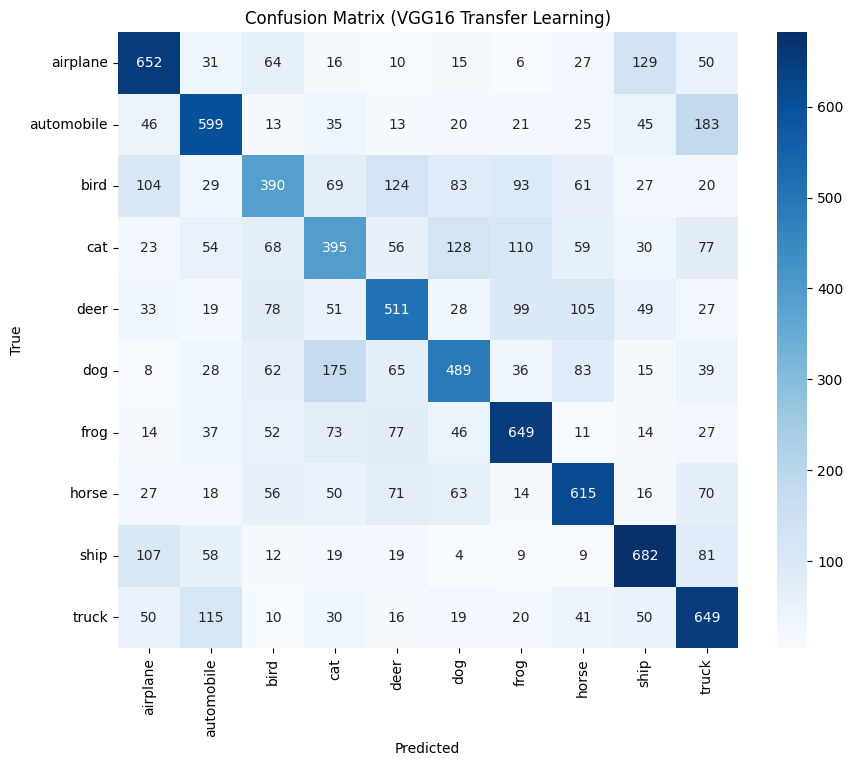

In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test.flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (VGG16 Transfer Learning)")
plt.show()

6. Plot Training Curves

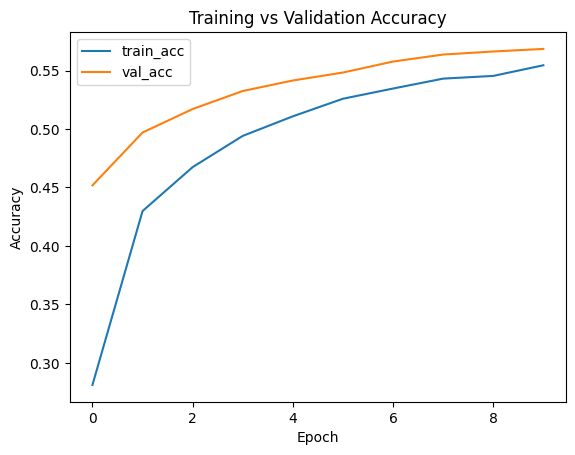

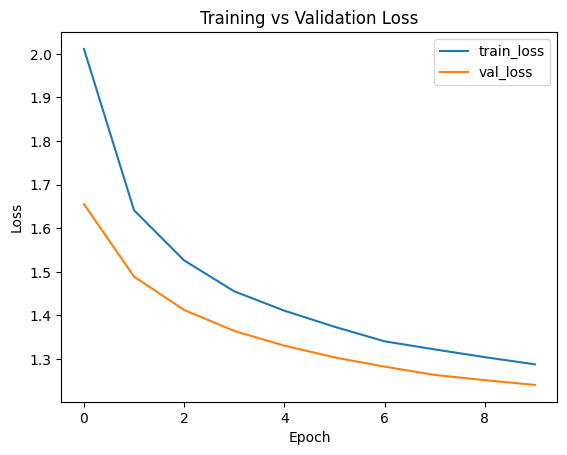

In [13]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()